In [60]:
import numpy as np
import cv2
import glob
from matplotlib import pyplot as plt
from copy import deepcopy

import torch
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn
from torch import optim
import torch.nn.functional as F

In [9]:
def solve(bo):
    find = find_empty(bo)
    if not find:  # ako je find = None ili False
        return True
    else:
        row, col = find

    for num in range(1, 10):
        if valid(bo, num, (row, col)):
            bo[row][col] = num
            
            if solve(bo):
                return True
            
            bo[row][col] = 0
    
    return False

In [10]:
def valid(bo, num, pos):

    # Preveri red
    for i in range(len(bo[0])):
        if bo[pos[0]][i] == num and pos[1] != i:
            return False

    # Proveri kolonu
    for i in range(len(bo)):
        if bo[i][pos[1]] == num and pos[0] != i:
            return False

    # Proveri kvadrat
    box_x = pos[1] // 3
    box_y = pos[0] // 3

    for i in range(box_y*3, box_y*3 + 3):
        for j in range(box_x*3, box_x*3 + 3):
            if bo[i][j] == num and (i, j) != pos:
                return False

    return True

In [11]:
def validate_inputs(bo):
    for i in range(9):
        for j in range(9):
            if bo[i][j] != 0 and not valid(bo, bo[i][j], (i, j)):
                return False
    return True

In [12]:
def find_empty(bo):
    for i in range(len(bo)):
        for j in range(len(bo[0])):
            if bo[i][j] == 0:
                return i, j  # red, kolona

    return None

In [13]:
# DataSet klasa, nasledjuje DataSet iz torch.utils.data
class DataSet(Dataset):
    def __init__(self):
        super().__init__()
        self.data = []
        self.labels = np.array([]).astype(np.long)
        
    def set_data(self, data_path):
        for i in range(1,10):
            images = [f for f in glob.glob(data_path + "/num_"+ str(i) + "/*.png")]
            self.labels = np.concatenate((self.labels, np.full(len(images), i)))
            for img in images:
                self.data.append(np.ravel(cv2.resize(cv2.imread(img, cv2.IMREAD_GRAYSCALE), (32,32))).astype(np.float32)/255)
        self.data = np.array(self.data)
        
    # Prazne slike, sa 35% sanse da doda liniju
    def empty(self, size):
        new_images = np.ones((size, 32, 32))
        for i in range(0, size, 4):
            r = np.random.randint(22,32)
            if r < 29 and np.random.rand() > 0.65:
                l = min(29-r, np.random.randint(1,3))

                new_images[i][29-r-l:29-r,:] = 0
                new_images[i+1][r+3:r+3+l,:] = 0
                new_images[i+2][:,29-r-l:29-r] = 0
                new_images[i+3][:,r+3:r+3+l] = 0
        self.data = np.concatenate((self.data, new_images.reshape(size, 1024).astype(np.float32)))
        self.labels = np.concatenate((self.labels, np.full(size, 0)))

    # Pomeranje u stranu, sa 35% sanse da doda liniju ako je dovoljno pomerno
    def shift_to_sides(self, size):
        labels = []
        new_images = np.ones((size, 32, 32))
        ones = np.ones((32,32))
        for i in range(0, size, 4):
            r = np.random.randint(22,32)
            ind = np.random.randint(len(self.data))
            labels.append(self.labels[ind])
            labels.append(self.labels[ind])
            labels.append(self.labels[ind])
            labels.append(self.labels[ind])
            new_images[i][32-r:,:] = self.data[ind].reshape(32, 32)[:r,:]
            new_images[i+1][:r,:] = self.data[ind].reshape(32, 32)[32-r:,:]
            new_images[i+2][:,32-r:] = self.data[ind].reshape(32, 32)[:,:r]
            new_images[i+3][:,:r] = self.data[ind].reshape(32, 32)[:,32-r:]
            
            if r < 29 and np.random.rand() > 0.65:
                l = min(29-r, np.random.randint(1,3))
                new_images[i][29-r-l:29-r,:] = 0
                new_images[i+1][r+3:r+3+l,:] = 0
                new_images[i+2][:,29-r-l:29-r] = 0
                new_images[i+3][:,r+3:r+3+l] = 0
            
        new_images = new_images.reshape(size, 1024).astype(np.float32)
        self.data = np.concatenate((self.data, new_images))
        self.labels = np.concatenate((self.labels, labels))

    def __getitem__(self, index):
        return self.data[index], self.labels[index]
    
    def __len__(self):
        return len(self.data)

In [14]:
ds_train = DataSet()
ds_train.set_data('training/')
# Na test dodajem 20000 pomerenih slika
ds_train.shift_to_sides(20000)
# Greska predstavlja praznu sliku, sa 65% mogucnosti za liniju
ds_train.empty(1000)


ds_test = DataSet()
ds_test.set_data('test/')
# Na train podacima dodajem 4000 pomerenih slika
ds_test.shift_to_sides(4000)
# Greska predstavlja praznu sliku
ds_test.empty(200)

In [15]:
# DataLoader da izmesa DataSet, i stavi batch size 10
train_loader = DataLoader(ds_train, shuffle=True, batch_size=10)
test_loader = DataLoader(ds_test, shuffle=True, batch_size=10)

In [16]:
# Klasa mreze, nasledjuje nn.Module
class Net(nn.Module):
    def __init__(self):
        # Ima 4 sloja, pokazalo se da sa ovim radi lepo
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1024, 600) # 1024 ulaza tj velicina slike
        self.fc2 = nn.Linear(600, 300)
        self.fc3 = nn.Linear(300, 170)
        self.fc4 = nn.Linear(170, 80)
        self.fc5 = nn.Linear(80, 10) # 10 izlaza, jer imamo 9 brojeva + gresku

    def forward(self, x):
        x = F.relu6(self.fc1(x))
        x = self.fc2(x)
        x = F.relu6(self.fc3(x))
        x = self.fc4(x)
        x = self.fc5(x)
        return x

In [17]:
# Device, ukoliko moze da se koristi GPU inace CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [18]:
net = Net()

# Setujemo da radi na GPU/CPU u zavisnosti da li je GPU slobodan
net.to(device)

# Loss funkcija
criterion = nn.CrossEntropyLoss()
# Optimizer
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Treniranje na 50 epoha, jer se pokazalo dovoljno
for epoch in range(50):
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 0:
            print("Gubitak: {:.3f}".format(running_loss/5))
            running_loss = 0.0
            
    print("Kraj epohe:", epoch + 1)
    
print("Kraj obucavanja")

Gubitak: 0.467
Gubitak: 46.025
Gubitak: 45.576
Gubitak: 45.284
Gubitak: 45.078
Gubitak: 45.097
Gubitak: 45.128
Gubitak: 44.967
Gubitak: 44.820
Gubitak: 44.126
Gubitak: 44.491
Gubitak: 43.998
Gubitak: 43.469
Gubitak: 42.917
Gubitak: 41.849
Gubitak: 40.364
Gubitak: 40.914
Gubitak: 39.220
Gubitak: 38.565
Gubitak: 38.105
Gubitak: 37.140
Gubitak: 37.070
Gubitak: 36.620
Gubitak: 35.658
Gubitak: 34.957
Gubitak: 34.989
Gubitak: 35.316
Gubitak: 34.919
Gubitak: 32.784
Gubitak: 34.066
Gubitak: 33.565
Gubitak: 32.999
Gubitak: 30.602
Gubitak: 30.737
Gubitak: 30.468
Gubitak: 30.582
Gubitak: 30.551
Gubitak: 27.761
Gubitak: 26.638
Gubitak: 28.086
Gubitak: 25.999
Gubitak: 27.196
Gubitak: 23.470
Gubitak: 24.651
Gubitak: 24.096
Gubitak: 24.699
Gubitak: 22.033
Gubitak: 22.225
Gubitak: 24.027
Gubitak: 23.527
Gubitak: 21.666
Gubitak: 22.430
Gubitak: 21.417
Gubitak: 19.399
Gubitak: 18.695
Gubitak: 20.098
Gubitak: 20.381
Gubitak: 20.703
Gubitak: 19.746
Gubitak: 18.924
Kraj epohe: 1
Gubitak: 0.139
Gubitak: 19.

Gubitak: 3.685
Gubitak: 3.623
Gubitak: 3.777
Gubitak: 4.310
Gubitak: 3.474
Gubitak: 2.757
Gubitak: 3.788
Gubitak: 3.447
Kraj epohe: 9
Gubitak: 0.002
Gubitak: 2.793
Gubitak: 2.752
Gubitak: 3.965
Gubitak: 2.819
Gubitak: 3.048
Gubitak: 2.830
Gubitak: 2.440
Gubitak: 3.565
Gubitak: 3.221
Gubitak: 3.649
Gubitak: 3.065
Gubitak: 2.936
Gubitak: 3.330
Gubitak: 3.446
Gubitak: 3.358
Gubitak: 3.475
Gubitak: 3.528
Gubitak: 3.100
Gubitak: 3.567
Gubitak: 2.736
Gubitak: 3.331
Gubitak: 3.170
Gubitak: 2.865
Gubitak: 2.830
Gubitak: 3.537
Gubitak: 3.700
Gubitak: 3.020
Gubitak: 3.814
Gubitak: 3.543
Gubitak: 3.294
Gubitak: 3.263
Gubitak: 3.611
Gubitak: 3.864
Gubitak: 3.549
Gubitak: 3.849
Gubitak: 2.566
Gubitak: 2.754
Gubitak: 2.351
Gubitak: 3.139
Gubitak: 3.572
Gubitak: 3.422
Gubitak: 4.228
Gubitak: 4.188
Gubitak: 3.155
Gubitak: 3.399
Gubitak: 3.398
Gubitak: 3.093
Gubitak: 3.119
Gubitak: 3.500
Gubitak: 3.812
Gubitak: 3.126
Gubitak: 3.452
Gubitak: 3.063
Gubitak: 3.434
Gubitak: 3.607
Gubitak: 3.552
Gubitak: 3.

Gubitak: 1.475
Gubitak: 2.725
Gubitak: 2.165
Gubitak: 2.004
Gubitak: 2.382
Gubitak: 2.455
Gubitak: 2.382
Gubitak: 2.451
Gubitak: 2.300
Gubitak: 2.566
Kraj epohe: 18
Gubitak: 0.001
Gubitak: 2.587
Gubitak: 1.843
Gubitak: 1.958
Gubitak: 1.711
Gubitak: 1.862
Gubitak: 1.976
Gubitak: 2.671
Gubitak: 2.634
Gubitak: 1.852
Gubitak: 2.299
Gubitak: 1.839
Gubitak: 1.575
Gubitak: 1.404
Gubitak: 2.559
Gubitak: 2.367
Gubitak: 1.839
Gubitak: 1.993
Gubitak: 2.447
Gubitak: 1.516
Gubitak: 1.986
Gubitak: 2.112
Gubitak: 1.349
Gubitak: 1.326
Gubitak: 1.795
Gubitak: 1.970
Gubitak: 2.396
Gubitak: 1.649
Gubitak: 2.416
Gubitak: 2.445
Gubitak: 2.736
Gubitak: 2.274
Gubitak: 1.771
Gubitak: 2.362
Gubitak: 1.877
Gubitak: 1.664
Gubitak: 1.308
Gubitak: 2.332
Gubitak: 2.036
Gubitak: 2.113
Gubitak: 1.107
Gubitak: 1.440
Gubitak: 1.989
Gubitak: 1.799
Gubitak: 1.917
Gubitak: 2.391
Gubitak: 2.402
Gubitak: 2.515
Gubitak: 1.973
Gubitak: 2.561
Gubitak: 2.122
Gubitak: 1.419
Gubitak: 2.585
Gubitak: 1.756
Gubitak: 2.082
Gubitak: 2

Gubitak: 1.698
Gubitak: 1.680
Gubitak: 2.344
Gubitak: 1.748
Gubitak: 1.133
Gubitak: 1.572
Gubitak: 1.821
Gubitak: 1.927
Gubitak: 1.733
Gubitak: 1.725
Gubitak: 1.952
Gubitak: 1.526
Kraj epohe: 27
Gubitak: 0.007
Gubitak: 1.363
Gubitak: 0.777
Gubitak: 1.152
Gubitak: 1.293
Gubitak: 1.293
Gubitak: 1.694
Gubitak: 1.812
Gubitak: 0.954
Gubitak: 1.155
Gubitak: 1.328
Gubitak: 1.216
Gubitak: 1.454
Gubitak: 1.535
Gubitak: 1.679
Gubitak: 2.240
Gubitak: 1.325
Gubitak: 1.210
Gubitak: 1.483
Gubitak: 1.489
Gubitak: 1.328
Gubitak: 0.866
Gubitak: 1.662
Gubitak: 1.356
Gubitak: 1.661
Gubitak: 1.247
Gubitak: 1.032
Gubitak: 1.154
Gubitak: 1.010
Gubitak: 1.493
Gubitak: 1.027
Gubitak: 1.628
Gubitak: 1.900
Gubitak: 1.767
Gubitak: 1.164
Gubitak: 0.982
Gubitak: 1.392
Gubitak: 1.266
Gubitak: 1.593
Gubitak: 1.437
Gubitak: 1.263
Gubitak: 1.111
Gubitak: 1.637
Gubitak: 1.399
Gubitak: 1.134
Gubitak: 1.469
Gubitak: 1.354
Gubitak: 1.002
Gubitak: 1.415
Gubitak: 1.297
Gubitak: 0.947
Gubitak: 1.759
Gubitak: 1.663
Gubitak: 1

Gubitak: 0.944
Gubitak: 1.110
Gubitak: 1.220
Gubitak: 0.995
Gubitak: 1.167
Gubitak: 1.158
Gubitak: 0.896
Gubitak: 0.984
Gubitak: 1.005
Gubitak: 1.016
Gubitak: 0.916
Gubitak: 1.280
Gubitak: 1.010
Gubitak: 0.813
Kraj epohe: 36
Gubitak: 0.005
Gubitak: 1.483
Gubitak: 1.019
Gubitak: 0.720
Gubitak: 1.031
Gubitak: 1.062
Gubitak: 1.571
Gubitak: 1.042
Gubitak: 1.071
Gubitak: 0.783
Gubitak: 0.662
Gubitak: 1.247
Gubitak: 0.828
Gubitak: 0.931
Gubitak: 0.656
Gubitak: 1.144
Gubitak: 0.725
Gubitak: 0.935
Gubitak: 0.789
Gubitak: 1.636
Gubitak: 1.168
Gubitak: 0.862
Gubitak: 1.027
Gubitak: 1.283
Gubitak: 1.579
Gubitak: 1.504
Gubitak: 0.980
Gubitak: 1.038
Gubitak: 1.658
Gubitak: 1.296
Gubitak: 0.888
Gubitak: 1.100
Gubitak: 0.833
Gubitak: 1.479
Gubitak: 1.351
Gubitak: 1.142
Gubitak: 1.333
Gubitak: 0.793
Gubitak: 0.939
Gubitak: 1.294
Gubitak: 0.953
Gubitak: 1.181
Gubitak: 1.750
Gubitak: 1.111
Gubitak: 1.651
Gubitak: 1.491
Gubitak: 0.922
Gubitak: 1.674
Gubitak: 1.604
Gubitak: 1.554
Gubitak: 0.791
Gubitak: 1

Gubitak: 0.998
Gubitak: 0.978
Gubitak: 0.668
Gubitak: 1.059
Gubitak: 0.911
Gubitak: 0.880
Gubitak: 0.803
Gubitak: 1.272
Gubitak: 0.803
Gubitak: 0.802
Gubitak: 1.434
Gubitak: 0.927
Gubitak: 0.787
Gubitak: 0.597
Gubitak: 0.799
Gubitak: 0.886
Kraj epohe: 45
Gubitak: 0.000
Gubitak: 0.502
Gubitak: 0.506
Gubitak: 1.171
Gubitak: 1.329
Gubitak: 1.275
Gubitak: 1.222
Gubitak: 1.383
Gubitak: 0.931
Gubitak: 1.102
Gubitak: 0.935
Gubitak: 1.496
Gubitak: 1.017
Gubitak: 1.708
Gubitak: 0.798
Gubitak: 0.579
Gubitak: 0.536
Gubitak: 0.845
Gubitak: 0.643
Gubitak: 0.546
Gubitak: 0.697
Gubitak: 0.683
Gubitak: 1.398
Gubitak: 1.349
Gubitak: 1.274
Gubitak: 0.484
Gubitak: 0.872
Gubitak: 0.685
Gubitak: 0.744
Gubitak: 1.048
Gubitak: 1.153
Gubitak: 0.940
Gubitak: 0.942
Gubitak: 0.792
Gubitak: 1.003
Gubitak: 0.913
Gubitak: 1.094
Gubitak: 0.774
Gubitak: 1.188
Gubitak: 0.971
Gubitak: 1.260
Gubitak: 0.921
Gubitak: 0.636
Gubitak: 1.024
Gubitak: 1.109
Gubitak: 0.793
Gubitak: 1.273
Gubitak: 1.918
Gubitak: 1.510
Gubitak: 1

In [19]:
total = 0
correct = 0

# Provera tacnosti
with torch.no_grad():
    for data in test_loader:
        features, labels = data
        features = features.to(device)
        labels = labels.to(device)
        outputs = net(features)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print("Tacnost: {:.3f}%".format(100 * correct / total))

Tacnost: 96.024%


In [20]:
# Vraca x,y,w,h sudokua na slici
def find_sudoku(image):
    # Adaptivni threshold
    image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 49, 3)
    image = (255 - image) # Inverse
    
    # Najveca kontura, najverovatnije je sudoku
    _, contours, hierarchy = cv2.findContours(image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True) # sortiramo ih po velici
    image = np.zeros(image.shape, dtype=np.uint8) # Matrica 0 iste velicine kao slika
    image = cv2.drawContours(image, [contours[0]], -1, (255, 255, 255), 3) # Lepimo najvecu konturu preko matrice nula
    
    return cv2.boundingRect(cv2.findNonZero(image)) # Vracamo boundingRect najvece konture

In [21]:
def get_number(roi, i, j, n):
        _, contours, hierarchy = cv2.findContours(cv2.convertScaleAbs(roi), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        contours = sorted(contours, key=cv2.contourArea, reverse=True)
        (xc, yc, wc, hc) = cv2.boundingRect(contours[0])
        sz = max(wc,hc)-n
        roi = cv2.resize(roi[yc+n:yc+sz,xc+n:xc+sz], (32,32))

        outputs = net.forward(torch.from_numpy(roi.ravel()).to(device))
        num = torch.exp(outputs).cpu().data.numpy().argmax()

        red = i*40+4
        kol = j*40+4
        snums[red:red+32,kol:kol+32] = roi
        kol += 394
        snums[red:red+32,kol:kol+32] = np.zeros((32,32))
        if num > 0:
            cv2.putText(snums, str(num), (kol+5, red+25), cv2.FONT_HERSHEY_SIMPLEX, 1, 1, 3, cv2.LINE_AA) 

        return num

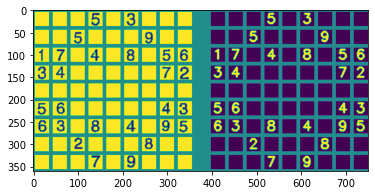

In [64]:
original = cv2.imread('original/38.jpg')
gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
snums = np.hstack((np.full((360, 360), 127)/255,np.full((360, 390), 127)/255))
positions = np.empty((9,9), dtype=object)

(x,y,w,h) = find_sudoku(gray)
sirina = int(w/9)
visina = int(h/9)
size = max([sirina, visina])
n = int(size/50)

gray = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 61, 11)
gray = cv2.dilate(gray, np.ones((3, 3), np.uint8), iterations=4)
gray = cv2.erode(gray, np.ones((3, 3), np.uint8), iterations=4)/255

sudoku = np.empty((9,9)).astype(np.int)
for i in range(9):
    for j in range(9):
        cy = int(x + sirina*j)
        cx = int(y + i*visina)
        roi = cv2.resize(gray[cx:cx+visina,cy:cy+sirina], (32,32)).astype(np.float32)
        
        sudoku[i][j] = get_number(roi, i, j, n)
plt.imshow(snums)

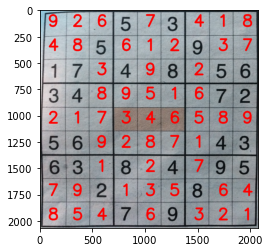

In [65]:
unsolved = deepcopy(sudoku)
if validate_inputs(sudoku):
    solve(sudoku)
    if not any(0 in x for x in sudoku):
        cropped_original = original[y:y+h,x:x+w].copy()
        for i in range(9):
            for j in range(9):
                if unsolved[i][j] == 0:
                    cx = int(sirina*j+(sirina/3))
                    cy = int(i*visina+(visina/1.5))
                    cv2.putText(cropped_original, str(sudoku[i][j]), (cx,cy), cv2.FONT_HERSHEY_SIMPLEX ,  
                           5, 255, 15, cv2.LINE_AA) 
        plt.imshow(cropped_original)
    else:
        print("Sudoku nije moguce resiti")
else:
    print("Sudoku nije validan")